In [88]:
from __future__ import division, print_function
import logging
import warnings
import numpy as np
from astropy.stats import sigma_clip
import os
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import bokeh  
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import LogColorMapper,LinearColorMapper, Selection, Slider, RangeSlider, Span, ColorBar, LogTicker, Range1d, Ticker, BasicTicker, Range1d
from bokeh.layouts import layout, Spacer
from bokeh.models.tools import HoverTool
from bokeh.models.widgets import Button, Div
from bokeh.models.formatters import PrintfTickFormatter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import lightkurve as lk
from scipy import stats
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from astropy import units as u
import scipy.optimize as opt

from photutils import centroids as cent


class PixelMapPeriodogram:
    """Object to hold 2D array of lk.periodgram object data .
    Attributes
    ----------
    targetpixelfile : targetpixelfile object
        
    Optional keywords accepted if ``method='lombscargle'`` are:
            ``minimum_frequency``, ``maximum_frequency``, ``mininum_period``,
            ``maximum_period``, ``frequency``, ``period``, ``nterms``,
            ``nyquist_factor``, ``oversample_factor``, ``freq_unit``,
            ``normalization``, ``ls_method``.
        
    """
    
    def __init__(self , targetpixelfile,**kwargs):

        #Defining an aperture that will be used in plotting and making empty 2-d arrays of the correct size for masks
        self.aperture = targetpixelfile.pipeline_mask
        self.tpf = targetpixelfile
        #Initiating a python list since this is computational slightly faster than a numpy array when initially storing periodogram
        pg = []

        
        #Iterating through columns of pixels
        for i in np.arange(0,len(self.aperture)):
            
            #Iterating through rws of pixels
            for j in np.arange(0,len(self.aperture[0])):
                
                
                #Making an empty 2-d array
                mask = np.zeros((len(self.aperture),len(self.aperture[0])), dtype=bool)
                
                #Iterating to isolate pixel by pixel to get light curves
                mask[i][j] = True
                
                #Getting the light curve for a pixel and excluding any flagged data
                lightcurve = targetpixelfile.to_lightcurve(aperture_mask=mask)
                lc = lightcurve[np.where(lightcurve.quality == 0)]
                lc = lc.remove_outliers()
                
                
                #if method == 'bls':
                    #Making a periodogram for the pixel
                    #periodogram = lc.to_periodogram(method = 'bls')
                    #periodogram.power = periodogram.power / np.median(periodogram.power)
                    #periodogram.power[np.where(periodogram.power<0)] = 0
                    #Extending the list of periodogram data for each pixel
                    #pg.extend([periodogram])
                #Making a periodogram for the pixel
                periodogram = lc.to_periodogram(**kwargs)
                #periodogram= periodogram.flatten()
                
                #Extending the list of periodogram data for each pixel
                pg.extend([periodogram])
                
        #Taking the final list and turning it into a 2-d numpy array witht he same dimensions of the full postage stamp      
        pg = np.reshape(np.asarray(pg),(len(self.aperture),len(self.aperture[0])))
        
        #Defining self.periodogram as this 2-d array of periodogram data
        self.periodogram = pg
        self.timeserieslength = (self.tpf.astropy_time.max()-self.tpf.astropy_time.min()).value
        self.gaiadata = None
        
        
    def plot(self):
        """
        Returns a plot of Frequency power spectrums for each pixel.
        """
        fig,ax = plt.subplots(len(self.aperture[0]),
                      len(self.aperture[1]),
                      figsize=(20,20),sharex='col', sharey='row')

        #Just making the subplot spacings 0 pixel width and height separation
        fig.subplots_adjust(wspace=0,hspace=0)
    
    
        #iterating through the columns of the postage stamp pixels
        for i in np.arange(0,len(self.aperture[0])):
    
            #iterating through the rows of the postage stamp pixels
            for j in np.arange(0,len(self.aperture[1])):
        
                #Creating a false mask to alter each iteration
                mask = np.empty((len(self.aperture),len(self.aperture[0])), dtype=bool)
            
                #setting one pixel in the postage stamp to have a lightcurve extracted and plotted
                mask[i][j] = True
                                  
        
                #Plotting the target pixel periodograph -- This can also be set up to have looks based on user input if desired
                ax[i][j].plot(self.periodogram[i][j].frequency,self.periodogram[i][j].power);
    
    def frequency_heat(self,low=0,high=1):
        """
        Returns a 2D array with the shape of the target pixel file of the integral of the frequency power spectrum.
        Attributes
        ----------
        low : float
            Lower bound for the integral of the power spectrum.
        high : float
            Upper bound for the integral of the power spectrum.
        """
        heat_stamp = []
        for i in np.arange(0,len(self.aperture)):
            for j in np.arange(0,len(self.aperture[0])):
                mask = np.zeros((len(self.aperture),len(self.aperture[0])), dtype=bool)
                mask[i][j] = True
                
                period = self.periodogram[mask][0]
                normperiod = np.asarray(period.power)/np.nanmedian(np.asarray(period.power))
                freq = np.asarray(period.frequency)
                sums = np.asarray(normperiod[np.where((freq < high) & (freq > low))]).sum()
                heat_stamp.extend([sums-len(np.where((freq < high) & (freq > low))[0])])
        heat_stamp = np.reshape(np.asarray(heat_stamp),(len(self.aperture),len(self.aperture[0])))
        
        return heat_stamp
    
    def gaia_figure_elements(self, magnitude_limit=18):
        """Make the Gaia Figure Elements"""
        tpf=self.tpf
        # Get the positions of the Gaia sources
        c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
        # Use pixel scale for query size
        pix_scale = 4.0  # arcseconds / pixel for Kepler, default
        if tpf.mission == 'TESS':
            pix_scale = 21.0
        # We are querying with a diameter as the radius, overfilling by 2x.
        from astroquery.vizier import Vizier
        Vizier.ROW_LIMIT = -1
        result = Vizier.query_region(c1, catalog=["I/345/gaia2"],radius=Angle(np.max(tpf.shape[1:]) * pix_scale, "arcsec"))

        no_targets_found_message = ValueError('Either no sources were found in the query region '
                                                  'or Vizier is unavailable')
        too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
        if result is None:
            raise no_targets_found_message
        elif len(result) == 0:
            raise too_few_found_message
        result = result["I/345/gaia2"].to_pandas()
        
        result = result[result.Gmag < magnitude_limit]
        if len(result) == 0:
            raise no_targets_found_message
            
        year = ((tpf.astropy_time[0].jd - 2457206.375) * u.day).to(u.year)
        pmra = ((np.nan_to_num(np.asarray(result.pmRA)) * u.milliarcsecond/u.year) * year).to(u.deg).value
        pmdec = ((np.nan_to_num(np.asarray(result.pmDE)) * u.milliarcsecond/u.year) * year).to(u.deg).value
        result.RA_ICRS += pmra
        result.DE_ICRS += pmdec
        radecs = np.vstack([result['RA_ICRS'], result['DE_ICRS']]).T
        coords = tpf.wcs.all_world2pix(radecs, 0) 
        


        # Gently size the points by their Gaia magnitude
        sizes = 64.0 / 2**(result['Gmag']/5.0)
        one_over_parallax = 1.0 / (result['Plx']/1000.)
        source = dict(ra=result['RA_ICRS'],
                      dec=result['DE_ICRS'],
                      source=result['Source'].astype(str),
                      Gmag=result['Gmag'],
                      plx=result['Plx'],
                      one_over_plx=one_over_parallax,
                      x=coords[:, 0],
                      y=coords[:, 1],
                      size=sizes)


        self.gaiadata = source
        
    def to_frequencymap(self,frequency_list):
        return frequency_heatmap(self.periodogram,self.timeserieslength,frequency_list,self.gaiadata)


    #need to add kwargs so it has the capability of running faster
    def show_interact_widget(self, notebook_url='localhost:8888',
                             aperture_mask='pipeline',
                             exported_filename=None):
        """Display an interactive Jupyter Notebook widget to inspect the pixel data.
        The widget will show both the frequency heatmap and pixel data.  The pixel data
        supports pixel selection via Bokeh tap and box select tools in an
        interactive javascript user interface.
        Note: at this time, this feature only works inside an active Jupyter
        Notebook, and tends to be slow.
        Parameters
        ----------
        tpf : lightkurve.TargetPixelFile
            Target Pixel File to interact with
        notebook_url: str
            Location of the Jupyter notebook page (default: "localhost:8888")
            When showing Bokeh applications, the Bokeh server must be
            explicitly configured to allow connections originating from
            different URLs. This parameter defaults to the standard notebook
            host and port. If you are running on a different location, you
            will need to supply this value for the application to display
            properly. If no protocol is supplied in the URL, e.g. if it is
            of the form "localhost:8888", then "http" will be used.
        
        """


        aperture_mask = self.tpf._parse_aperture_mask(aperture_mask)

        #Getting the light curve for a pixel and excluding any flagged data
        lightcurve = self.tpf.to_lightcurve(aperture_mask=aperture_mask)
        lc = lightcurve[np.where(lightcurve.quality == 0)]
        lc = lc.flatten(window_length=3001)
        #lc = lc.remove_outliers()

        #Making a periodogram for the pixel
        #need to make this a kwarg min max freq or freq
        periodogram = lc.to_periodogram(minimum_frequency = 1,maximum_frequency=1000,freq_unit= u.microHertz)
        periodogram= periodogram.flatten()
        pg = periodogram





        npix = self.tpf.flux[0, :, :].size
        pixel_index_array = np.arange(0, npix, 1).reshape(self.tpf.flux[0].shape)
        
        def prepare_tpf_datasource(tpf, aperture_mask):
            """Prepare a bokeh DataSource object for selection glyphs
            Parameters
            ----------
            tpf : TargetPixelFile
                TPF to be shown.
            aperture_mask : boolean numpy array
                The Aperture mask applied at the startup of interact
            Returns
            -------
            tpf_source : bokeh.plotting.ColumnDataSource
                Bokeh object to be shown.
            """
            npix = tpf.flux[0, :, :].size
            pixel_index_array = np.arange(0, npix, 1).reshape(tpf.flux[0].shape)
            xx = tpf.column + np.arange(tpf.shape[2])
            yy = tpf.row + np.arange(tpf.shape[1])
            xa, ya = np.meshgrid(xx, yy)
            preselected = Selection()
            preselected.indices = pixel_index_array[aperture_mask].reshape(-1).tolist()
            tpf_source = ColumnDataSource(data=dict(xx=xa+0.5, yy=ya+0.5),
                                          selected=preselected)
            return tpf_source

        def prepare_periodogram_datasource(pg):
            """Prepare a bokeh ColumnDataSource object for tool tips.
            Parameters
            ----------
            pg : Periodogram object
            Returns
            -------
            pg_source : bokeh.plotting.ColumnDataSource
            """
            # Convert time into human readable strings, breaks with NaN time
            # See https://github.com/KeplerGO/lightkurve/issues/116




            pg_source = ColumnDataSource(data=dict(power=pg.power,frequency=pg.frequency))
            return pg_source





        def get_periodogram_y_limits(pg_source):
            """Compute sensible defaults for the Y axis limits of the periodogram plot.
            Parameters
            ----------
            pg_source : bokeh.plotting.ColumnDataSource
                The periodogram being shown.
            Returns
            -------
            ymin, ymax : float, float
                Power min and max limits.
            """
            #ask about this sigma clip
            power = pg_source.data['power']

            low = float(power.min())
            high = float(power.max())
            margin = 0.10 * (high - low)
            return low, high


        def make_periodogram_figure_elements(pg, pg_source,lc):
            """Make the periodogram figure elements.
            Parameters
            ----------
            pg : Periodogram
                Periodogram to be shown.
            pg_source : bokeh.plotting.ColumnDataSource
                Bokeh object that enables the visualization.
            Returns
            ----------
            fig : `bokeh.plotting.figure` instance
            step_renderer : GlyphRenderer
            vertical_line : Span
            """
            if lc.mission == 'K2':
                title = "Periodogram for {} (K2)".format(
                    pg.label)
            elif lc.mission == 'Kepler':
                title = "Periodogram for {} (Kepler)".format(
                    pg.label)
            elif lc.mission == 'TESS':
                title = "Periodogram for {} (TESS)".format(
                    pg.label)
            else:
                title = "Periodogram for target {}".format(pg.label)

            fig = figure(title=title, plot_height=340, plot_width=600,
                         tools="pan,wheel_zoom,box_zoom,tap,reset",
                         toolbar_location="below",
                         border_fill_color="whitesmoke")
            fig.title.offset = -10
            fig.yaxis.axis_label = 'Power (unit)'
            fig.xaxis.axis_label = 'Frequency (unit)'


            ylims = get_periodogram_y_limits(pg_source)
            fig.y_range = Range1d(start=ylims[0], end=ylims[1])





            # Add step lines, circles, and hover-over tooltips
            fig.step('frequency', 'power', line_width=1, color='gray',
                     source=pg_source, nonselection_line_color='gray',
                     nonselection_line_alpha=1.0)
            circ = fig.circle('frequency', 'power', source=pg_source, fill_alpha=0.3, size=8,
                              line_color=None, selection_color="firebrick",
                              nonselection_fill_alpha=0.0,
                              nonselection_fill_color="grey",
                              nonselection_line_color=None,
                              nonselection_line_alpha=0.0,
                              fill_color=None, hover_fill_color="firebrick",
                              hover_alpha=0.9, hover_line_color="white")
            tooltips = [("frequency", "@frequency"),
                        ("power", "@power")]
            fig.add_tools(HoverTool(tooltips=tooltips, renderers=[circ],
                                    mode='mouse', point_policy="snap_to_data"))





            # Vertical line to indicate the frequency
            #vertical_line = Span(location=pg.frequency[0], dimension='height',
                                 #line_color='firebrick', line_width=4, line_alpha=0.5)
            #fig.add_layout(vertical_line)

            return fig#, vertical_line


        def add_gaia_figure_elements(tpf, fig, magnitude_limit=18):
            """Make the Gaia Figure Elements"""
            # Get the positions of the Gaia sources
            c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
            # Use pixel scale for query size
            pix_scale = 4.0  # arcseconds / pixel for Kepler, default
            if tpf.mission == 'TESS':
                pix_scale = 21.0
            # We are querying with a diameter as the radius, overfilling by 2x.
            from astroquery.vizier import Vizier
            Vizier.ROW_LIMIT = -1
            result = Vizier.query_region(c1, catalog=["I/345/gaia2"],
                                         radius=Angle(np.max(tpf.shape[1:]) * pix_scale, "arcsec"))
            no_targets_found_message = ValueError('Either no sources were found in the query region '
                                                  'or Vizier is unavailable')
            too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
            if result is None:
                raise no_targets_found_message
            elif len(result) == 0:
                raise too_few_found_message
            result = result["I/345/gaia2"].to_pandas()
            result = result[result.Gmag < magnitude_limit]
            if len(result) == 0:
                raise no_targets_found_message
            radecs = np.vstack([result['RA_ICRS'], result['DE_ICRS']]).T
            
            year = ((tpf.astropy_time[0].jd - 2457206.375) * u.day).to(u.year)
            pmra = ((np.nan_to_num(np.asarray(result.pmRA)) * u.milliarcsecond/u.year) * year).to(u.deg).value
            pmdec = ((np.nan_to_num(np.asarray(result.pmDE)) * u.milliarcsecond/u.year) * year).to(u.deg).value
            result.RA_ICRS += pmra
            result.DE_ICRS += pmdec
            coords = tpf.wcs.all_world2pix(radecs, 1)

            # Gently size the points by their Gaia magnitude
            sizes = 64.0 / 2**(result['Gmag']/5.0)
            one_over_parallax = 1.0 / (result['Plx']/1000.)
            source = ColumnDataSource(data=dict(ra=result['RA_ICRS'],
                                                dec=result['DE_ICRS'],
                                                source=result['Source'].astype(str),
                                                Gmag=result['Gmag'],
                                                plx=result['Plx'],
                                                one_over_plx=one_over_parallax,
                                                x=coords[:, 0]+tpf.column,
                                                y=coords[:, 1]+tpf.row,
                                                size=sizes))

            r = fig.circle('x', 'y', source=source, fill_alpha=0.3, size='size',
                           line_color=None, selection_color="firebrick",
                           nonselection_fill_alpha=0.0, nonselection_line_color=None,
                           nonselection_line_alpha=0.0, fill_color="firebrick",
                           hover_fill_color="firebrick", hover_alpha=0.9,
                           hover_line_color="white")

            fig.add_tools(HoverTool(tooltips=[("Gaia source", "@source"),
                                              ("G", "@Gmag"),
                                              ("Parallax (mas)", "@plx (~@one_over_plx{0,0} pc)"),
                                              ("RA", "@ra{0,0.00000000}"),
                                              ("DEC", "@dec{0,0.00000000}"),
                                              ("x", "@x"),
                                              ("y", "@y")],
                                    renderers=[r],
                                    mode='mouse',
                                    point_policy="snap_to_data"))
            return fig, r


        def make_tpf_figure_elements(tpf, tpf_source,pg, pedestal=None, fiducial_frame=None,
                                     plot_width=370, plot_height=340):
            """Returns the periodogram figure elements.
            Parameters
            ----------
            tpf : TargetPixelFile
                TPF to show.
            tpf_source : bokeh.plotting.ColumnDataSource
                TPF data source.
            pedestal: float
                A scalar value to be added to the TPF flux values, often to avoid
                taking the log of a negative number in colorbars.
                Defaults to `-min(tpf.flux) + 1`
            fiducial_frame: int
                The tpf slice to start with by default, it is assumed the WCS
                is exact for this frame.
            Returns
            -------
            fig, stretch_slider : bokeh.plotting.figure.Figure, RangeSlider
            """

            low = float(np.min(np.asarray(pg.frequency)))
            high = float(np.max(np.asarray(pg.frequency)))

            if tpf.mission in ['Kepler', 'K2']:
                title = 'Pixel data (CCD {}.{})'.format(tpf.module, tpf.output)
            elif tpf.mission == 'TESS':
                title = 'Pixel data (Camera {}.{})'.format(tpf.camera, tpf.ccd)
            else:
                title = "Pixel data"

            fig = figure(plot_width=plot_width, plot_height=plot_height,
                         x_range=(tpf.column-.5, tpf.column-.5+tpf.shape[2]),
                         y_range=(tpf.row-.5, tpf.row-.5+tpf.shape[1]),
                         title=title, tools='tap,box_select,wheel_zoom,reset',
                         toolbar_location="below",
                         border_fill_color="whitesmoke")

            fig.yaxis.axis_label = 'Pixel Row Number'
            fig.xaxis.axis_label = 'Pixel Column Number'

            color_mapper = LinearColorMapper(palette="Viridis256", low=low, high=high)

            def origin(tpf):
                tpfperiod=PixelMapPeriodogram(tpf)
                heat_stamp = []
                aperture = tpf.pipeline_mask
                for i in np.arange(0,len(aperture)):
                    for j in np.arange(0,len(aperture[0])):
                        mask = np.zeros((len(aperture),len(aperture[0])), dtype=bool)
                        mask[i][j] = True

                        period = tpfperiod.periodogram[mask][0]
                        freq = np.asarray(period.frequency)
                        sums = np.asarray(period.power[np.where((freq < high) & (freq > low))]).sum()
                        heat_stamp.extend([sums])

                heat_stamp = np.reshape(np.asarray(heat_stamp),(len(aperture),len(aperture[0])))
                return heat_stamp,tpfperiod
    
            heat_stamp,tpfperiod = origin(tpf)
            fig.image(image = [heat_stamp], x=tpf.column-.5, y=tpf.row-.5,
                      dw=tpf.shape[2], dh=tpf.shape[1], dilate=True,
                      color_mapper=color_mapper, name="tpfimg")


            # The colorbar will update with the screen stretch slider
            # The colorbar margin increases as the length of the tick labels grows.
            # This colorbar share of the plot window grows, shrinking plot area.
            # This effect is known, some workarounds might work to fix the plot area:
            # https://github.com/bokeh/bokeh/issues/5186
            color_bar = ColorBar(color_mapper=color_mapper,
                                 ticker=BasicTicker(desired_num_ticks=8),    #LogTicker
                                 label_standoff=-10, border_line_color=None,
                                 location=(0, 0), background_fill_color='whitesmoke',
                                 major_label_text_align='left',
                                 major_label_text_baseline='middle',
                                 title='Power', margin=0)
            fig.add_layout(color_bar, 'right')

            color_bar.formatter = PrintfTickFormatter(format="%14u")

            if tpf_source is not None:
                fig.rect('xx', 'yy', 1, 1, source=tpf_source, fill_color='gray',
                        fill_alpha=0.4, line_color='white')

            # Configure the stretch slider and its callback function
            stretch_slider = RangeSlider(start=low,
                                         end=high,
                                         step=.1,
                                         title='Frequency Range',
                                         value=(low, high),
                                         orientation='horizontal',
                                         width=600,
                                         height=10,
                                         direction='ltr',
                                         show_value=True,
                                         sizing_mode='fixed',
                                         name='frequencyrange')





            def stretch_change_callback(attr, old, new):
                """TPF stretch slider callback."""


                aperture = tpf.pipeline_mask
                heat_stamp=[]
                for i in np.arange(0,len(aperture)):
                    for j in np.arange(0,len(aperture[0])):
                        mask = np.zeros((len(aperture),len(aperture[0])), dtype=bool)
                        mask[i][j] = True


                        period = tpfperiod.periodogram[mask][0]
                        normperiod = np.asarray(period.power)/np.nanmedian(np.asarray(period.power))
                        freq = np.asarray(period.frequency)
                        sums = np.asarray(normperiod[np.where((freq < new[1]) & (freq > new[0]))]).sum()
                        heat_stamp.extend([sums-len(np.where((freq < new[1]) & (freq > new[0]))[0])])
                fig.select('tpfimg')[0].data_source.data['image'] = [np.reshape(np.asarray(heat_stamp),(len(aperture),len(aperture[0])))]
                fig.select('tpfimg')[0].glyph.color_mapper.high = max(heat_stamp)
                fig.select('tpfimg')[0].glyph.color_mapper.low = min(heat_stamp)

            stretch_slider.on_change('value', stretch_change_callback)

            return fig, stretch_slider
    
        def make_default_export_name(tpf, suffix='custom-pg'):
            """makes the default name to save a custom intetract mask"""
            fn = tpf.hdu.filename()
            if fn is None:
                outname = "{}_{}_{}.fits".format(tpf.mission, tpf.targetid, suffix)
            else:
                base = os.path.basename(fn)
                outname = base.rsplit('.fits')[0] + '-{}.fits'.format(suffix)
            return outname

        def create_interact_ui(doc):
            # The data source includes metadata for hover-over tooltips
            pg_source = prepare_periodogram_datasource(pg)
            tpf_source = prepare_tpf_datasource(self.tpf, aperture_mask)

            # Create the periodogram figure and its vertical marker
            fig_pg = make_periodogram_figure_elements(pg, pg_source,lc)

            # Create the TPF figure and its stretch slider
            fig_tpf, stretch_slider = make_tpf_figure_elements(self.tpf, tpf_source,pg,
                                                               fiducial_frame=0)

            r_button = Button(label=">", button_type="default", width=30)
            l_button = Button(label="<", button_type="default", width=30)
            export_button = Button(label="Save Periodogram",
                                   button_type="success", width=120)
            message_on_save = Div(text=' ',width=600, height=15)


            # Callbacks
            def update_upon_pixel_selection(attr, old, new):
                """Callback to take action when pixels are selected."""
                # Check if a selection was "re-clicked", then de-select
                if ((sorted(old) == sorted(new)) & (new != [])):
                    # Trigger recursion
                    tpf_source.selected.indices = new[1:]

                if new != []:
                    selected_indices = np.array(new)
                    selected_mask = np.isin(pixel_index_array, selected_indices)
                    lc_new = self.tpf.to_lightcurve(aperture_mask=selected_mask)
                    lc_new = lc_new[np.where(lc_new.quality == 0)]
                    lc_new = lc_new.flatten(window_length=3001)
                    #lc_new = lc_new.remove_outliers()
                    pg_new = lc_new.to_periodogram(oversample_factor=5)
                    pg_new = pg_new.flatten()
                    pg_source.data['power'] = pg_new.power
                    pg_source.data['frequency'] = pg_new.frequency
                    ylims = get_periodogram_y_limits(pg_source)
                    fig_pg.y_range.start = ylims[0]
                    fig_pg.y_range.end = ylims[1]
                else:
                    pg_source.data['power'] = pg.power * 0.0
                    fig_pg.y_range.start = -1
                    fig_pg.y_range.end = 1

                message_on_save.text = " "
                export_button.button_type = "success"

            #def update_upon_cadence_change(attr, old, new):
             #   """Callback to take action when cadence slider changes"""
              #  if new in tpf.cadenceno:
              #      frameno = tpf_index_lookup[new]
               #     fig_tpf.select('tpfimg')[0].data_source.data['image'] = \
                #        [tpf.flux[frameno, :, :] + pedestal]
                 #   vertical_line.update(location=tpf.time[frameno])
                #else:
                 #   fig_tpf.select('tpfimg')[0].data_source.data['image'] = \
                  #      [tpf.flux[0, :, :] * np.NaN]
                #lc_source.selected.indices = []
            #currently not in use
            def go_right_by_one():
                """Step forward in time by a single cadence"""
                existing_value = cadence_slider.value
                if existing_value < np.max(self.tpf.cadenceno):
                    cadence_slider.value = existing_value + 1
            #currently not in use
            def go_left_by_one():
                """Step back in time by a single cadence"""
                existing_value = cadence_slider.value
                if existing_value > np.min(self.tpf.cadenceno):
                    cadence_slider.value = existing_value - 1

            def save_periodogram():
                """Save the periodogram as a fits file with mask as HDU extension"""
                if tpf_source.selected.indices != []:
                    selected_indices = np.array(tpf_source.selected.indices)
                    selected_mask = np.isin(pixel_index_array, selected_indices)
                    lc_new = self.tpf.to_lightcurve(aperture_mask=selected_mask)
                    lc_new = lc_new[np.where(lc_new.quality == 0)]
                    lc_new = lc_new.flatten(window_length=3001)
                    #lc_new = lc_new.remove_outliers()
                    pg_new = lc_new.to_periodogram(oversample_factor=5)
                    pg_new = pg_new.flatten()
                    pg_new.to_fits(exported_filename, overwrite=True,
                                   power_column_name='SAP_POWER',
                                   aperture_mask=selected_mask.astype(np.int),
                                   SOURCE='lightkurve interact',
                                   NOTE='custom mask',
                                   MASKNPIX=np.nansum(selected_mask))
                    if message_on_save.text == " ":
                        text = '<font color="black"><i>Saved file {} </i></font>'
                        message_on_save.text = text.format(exported_filename)
                        export_button.button_type = "success"
                    else:
                        text = '<font color="gray"><i>Saved file {} </i></font>'
                        message_on_save.text = text.format(exported_filename)
                else:
                    text = '<font color="gray"><i>No pixels selected, no mask saved</i></font>'
                    export_button.button_type = "warning"
                    message_on_save.text = text

            #def jump_to_lightcurve_position(attr, old, new):
            #    if new != []:
            #        cadence_slider.value = lc.cadenceno[new[0]]

            # Map changes to callbacks
            r_button.on_click(go_right_by_one)
            l_button.on_click(go_left_by_one)
            export_button = Button(label="Save Periodogram",
                                   button_type="success", width=120)
            tpf_source.selected.on_change('indices', update_upon_pixel_selection)
            export_button.on_click(save_periodogram)
            #cadence_slider.on_change('value', update_upon_cadence_change)

            # Layout all of the plots
            sp1, sp2, sp3, sp4 = (Spacer(width=15), Spacer(width=30),
                                  Spacer(width=80), Spacer(width=60))
            widgets_and_figures = layout([fig_pg, fig_tpf],
                                         [l_button, sp1, r_button, sp2, sp3, stretch_slider],
                                         [export_button, sp4, message_on_save])
            #removed cadence slider
            doc.add_root(widgets_and_figures)

        output_notebook(verbose=False, hide_banner=True)
        return show(create_interact_ui, notebook_url=notebook_url)



        def create_interact_ui(doc):
            # The data source includes metadata for hover-over tooltips
            tpf_source = None

            # Create the TPF figure and its stretch slider
            fig_tpf, stretch_slider = make_tpf_figure_elements(self.tpf, tpf_source,pg,
                                                    fiducial_frame=fiducial_frame,
                                                    plot_width=640, plot_height=600)
            fig_tpf, r = add_gaia_figure_elements(self.tpf, fig_tpf,
                                                  magnitude_limit=magnitude_limit)

            # Optionally override the default title
            if self.tpf.mission == 'K2':
                fig_tpf.title.text = "Skyview for EPIC {}, K2 Campaign {}, CCD {}.{}".format(
                                    self.tpf.targetid, self.tpf.campaign, self.tpf.module, self.tpf.output)
            elif self.tpf.mission == 'Kepler':
                fig_tpf.title.text = "Skyview for KIC {}, Kepler Quarter {}, CCD {}.{}".format(
                                self.tpf.targetid, self.tpf.quarter, self.tpf.module, self.tpf.output)
            elif self.tpf.mission == 'TESS':
                fig_tpf.title.text = 'Skyview for TESS {} Sector {}, Camera {}.{}'.format(
                                self.tpf.targetid, self.tpf.sector, self.tpf.camera, self.tpf.ccd)

            # Layout all of the plots
            widgets_and_figures = layout([fig_tpf, stretch_slider])
            doc.add_root(widgets_and_figures)

        output_notebook(verbose=False, hide_banner=True)
        return show(create_interact_ui, notebook_url=notebook_url)




In [89]:
class frequency_heatmap:

    def __init__(self,pg,time_series_length,frequency_list,gaia_data):
        heat_stamp = []

        for i in np.arange(0,len(pg)):
            for j in np.arange(0,len(pg[0])):
                mask = np.zeros((len(pg),len(pg[0])), dtype=bool)
                mask[i][j] = True

                period = pg[mask][0].flatten(method='logmedian',filter_width = .1)
                normperiod = np.asarray(period.power)#/np.nanmedian(np.asarray(period.power))
                freq = np.asarray(period.frequency)
                sums = 0 
                background = 0
                for k in np.arange(len(frequency_list)):
                    sums += np.asarray(normperiod[np.where((freq < frequency_list[k]+(1/(2*time_series_length)) ) & (freq > frequency_list[k]-(1/(2*time_series_length))))]).sum()
                    #background += len(np.where((freq < frequency_list[k]+(1/(2*time_series_length)) ) & (freq > frequency_list[k]-(1/(2*time_series_length))))[0])#*np.nanmedian(np.asarray(period.power))
                heat_stamp.extend([sums-background])

        self.heat_stamp = np.reshape(np.asarray(heat_stamp),(len(pg),len(pg[0])))
        self.gaiadata=gaia_data
    def centroid(self):
        #same sigma, assuming symmetrical distributed psf
        def two_dGaussian( shape , amplitude, xo, yo, sigma):
            x,y = np.meshgrid(shape[0],shape[1])
            xo = float(xo)
            yo = float(yo)    
            a = 1/(2*sigma**2)
            g = np.abs(amplitude)*np.exp( - (a*((x-xo)**2) + a*((y-yo)**2)))
            return g.flatten()

        c = cent.centroid_2dg(self.heat_stamp)
        x = np.arange(0,np.shape(self.heat_stamp)[0])
        y = np.arange(0,np.shape(self.heat_stamp)[1])

        initial_guess = (self.heat_stamp.max(),c[0],c[1],1)
        popt, pcov = opt.curve_fit(two_dGaussian, (x,y),self.heat_stamp.flatten(), p0=initial_guess)

        self.x = popt[1]
        self.y = popt[2]
        self.covariance=pcov
    def closest_star(self):
        gaia_data = self.gaiadata
        no_gaia_data_message = ValueError('No gaia data initialized in PixelMapPeriodogram class')
        if gaia_data ==None :
            raise no_gaia_data_message
            
        else:    
            closest_star_mask = np.where(np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y'])==(np.square(self.x-gaia_data['x'])+np.square(self.y-gaia_data['y'])).min())
            self.closeststar = dict(ra = np.asarray(gaia_data['ra'])[closest_star_mask],
                                    dec = np.asarray(gaia_data['dec'])[closest_star_mask],
                                    source = np.asarray(gaia_data['source'])[closest_star_mask],
                                    x = np.asarray(gaia_data['x'])[closest_star_mask],
                                    y = np.asarray(gaia_data['y'])[closest_star_mask],
                                    size = np.asarray(gaia_data['size'])[closest_star_mask])



# Example of Use:

## Initialize Target Pixel File Object

In [139]:
search_result = lk.search_targetpixelfile('TIC239678779', mission='TESS', sector=19)
tpf = search_result.download(quality_bitmask='default')

In [3]:
search_result = lk.search_targetpixelfile('TIC257459955', mission='TESS', sector=3)
tpf = search_result.download(quality_bitmask='default')

## Initialize Pixel Map Periodogram Object

In [90]:
pmp = PixelMapPeriodogram(tpf,minimum_frequency = 1,maximum_frequency=2000,freq_unit= u.microHertz)

## Create a grid plot

## Create and plot Frequency Heat Map for frequencies of interest.

In [11]:
#create frequency heat map
pmp.gaia_figure_elements()
frequencyheatmapclass = pmp.to_frequencymap(frequency_list=[97.87963868,92.03828453])

In [91]:
pmp.gaia_figure_elements()
frequencyheatmapclass = pmp.to_frequencymap(frequency_list=[1561.200,1473.985,1673.490])

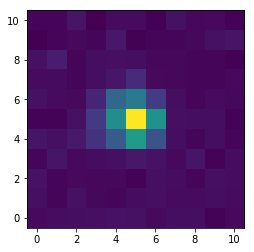

In [92]:
plt.imshow(frequencyheatmapclass.heat_stamp,origin=0)



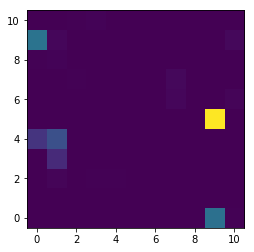

In [72]:
tpf.lightcur


## Find the Centroid

(-0.5, 10.5)

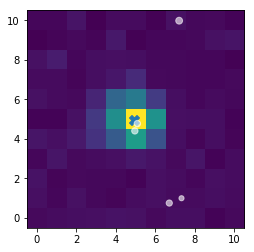

In [93]:
plt.imshow(frequencyheatmapclass.heat_stamp,origin=0)
#plot the centroid
frequencyheatmapclass.centroid()
plt.scatter(frequencyheatmapclass.x,frequencyheatmapclass.y,marker='X',s=100)
plt.scatter(pmp.gaiadata['x'],pmp.gaiadata['y'],s=pmp.gaiadata['size']*5,c='white',alpha=.6)
plt.xlim(-.5,10.5)
plt.ylim(-.5,10.5)


In [94]:
np.median(pmp.periodogram[10][10].power)

<Quantity 0.01822923 electron / s>

In [68]:
np.median(pmp.periodogram[5][5].power)

<Quantity 0.0280779 electron / s>

In [95]:
np.median(pmp.periodogram[10][10].power)

<Quantity 0.01822923 electron / s>

In [96]:
np.median(pmp.periodogram[5][5].power)

<Quantity 0.0280779 electron / s>

## Situation Concern:

    1. variable star in field
    2. White noise variability 
    3. Blended with red giant type object (large noise from variability)
    4.

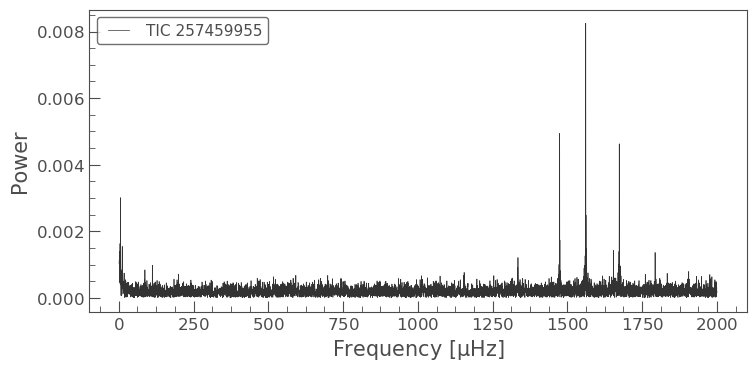

In [84]:
pmp.periodogram[5][5].plot()

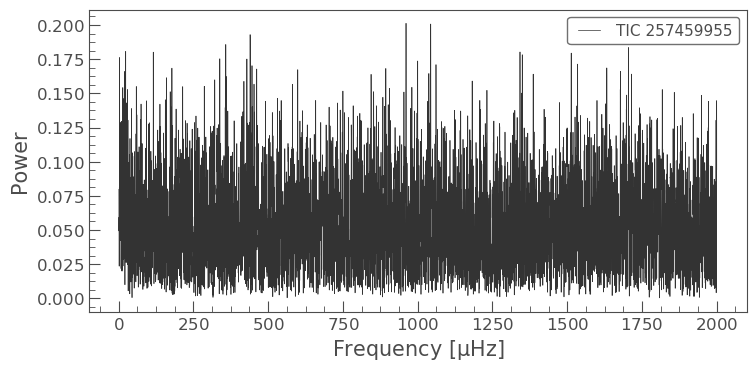

In [85]:
pmp.periodogram[10][10].plot()

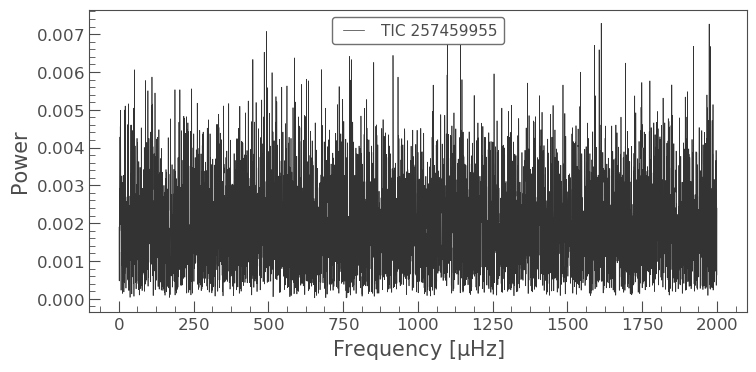

In [86]:
pmp.periodogram[9][5].plot()

In [9]:

frequencyheatmapclass.closest_star()

In [159]:
np.sqrt(np.diagonal(frequencyheatmapclass.covariance))

array([0.17230966, 0.03562131, 0.0358277 , 0.02136844])

In [3]:
search_result1 = lk.search_targetpixelfile('TIC164654552', mission='TESS')
tpf1 = search_result1.download(quality_bitmask='default')

In [4]:
search_result2 = lk.search_targetpixelfile('TIC121022767', mission='TESS')
tpf2 = search_result2.download(quality_bitmask='default')

In [5]:
search_result3 = lk.search_targetpixelfile('TIC171098521', mission='TESS')
tpf3 = search_result3.download(quality_bitmask='default')

In [6]:
search_result4 = lk.search_targetpixelfile('TIC121939266', mission='TESS')
tpf4 = search_result4.download(quality_bitmask='default')

In [7]:
search_result5 = lk.search_targetpixelfile('TIC172422313', mission='TESS')
tpf5 = search_result5.download(quality_bitmask='default')

C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\search.py:185: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


In [8]:
search_result6 = lk.search_targetpixelfile('TIC27533798', mission='TESS')
tpf6 = search_result6.download(quality_bitmask='default')

C:\Users\higgi\Anaconda3\lib\site-packages\lightkurve\search.py:185: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


In [9]:
search_result7 = lk.search_targetpixelfile('TIC416266231', mission='TESS')
tpf7 = search_result7.download(quality_bitmask='default')

In [10]:
search_result8 = lk.search_targetpixelfile('TIC164833828', mission='TESS')
tpf8 = search_result8.download(quality_bitmask='default')

In [93]:
pmp1 = PixelMapPeriodogram(tpf1,minimum_frequency = 0.1,maximum_frequency=2.5,freq_unit= 1/u.d)
pmp1.gaia_figure_elements()

In [111]:
pmp2 = PixelMapPeriodogram(tpf2,minimum_frequency = 0.1,maximum_frequency=2.5,freq_unit= 1/u.d)
pmp2.gaia_figure_elements()

In [13]:
pmp3 = PixelMapPeriodogram(tpf3,minimum_frequency = 0.1,maximum_frequency=2.5,freq_unit= 1/u.d)
pmp3.gaia_figure_elements()

In [14]:
pmp4 = PixelMapPeriodogram(tpf4,minimum_frequency = 0.1,maximum_frequency=2.5,freq_unit= 1/u.d)
pmp4.gaia_figure_elements()

In [15]:
pmp5 = PixelMapPeriodogram(tpf5,minimum_frequency = 0.1,maximum_frequency=2.5,freq_unit= 1/u.d)
pmp5.gaia_figure_elements()

In [16]:
pmp6 = PixelMapPeriodogram(tpf6,minimum_frequency = 0.1,maximum_frequency=2.5,freq_unit= 1/u.d)
pmp6.gaia_figure_elements()

In [17]:
pmp7 = PixelMapPeriodogram(tpf7,minimum_frequency = 0.1,maximum_frequency=2.5,freq_unit= 1/u.d)
pmp7.gaia_figure_elements()

In [18]:
pmp8 = PixelMapPeriodogram(tpf8,minimum_frequency = 0.1,maximum_frequency=2.5,freq_unit= 1/u.d)
pmp8.gaia_figure_elements()

In [30]:
kfreq = 1/np.asarray([1,39.59,37.057,47.769,18.22,41.021,44.947,16.114,23.859])
tfreq = 1/np.asarray([1,1.67567,1.99372,2.07708,1.91456,2.20139,0.96111,0.43611,1.73679])

{'ra': array([286.84632204]),
 'dec': array([37.69701039]),
 'source': array(['2099128058624440320'], dtype=object),
 'x': array([3.20827416]),
 'y': array([4.59809886]),
 'size': array([14.40662007])}

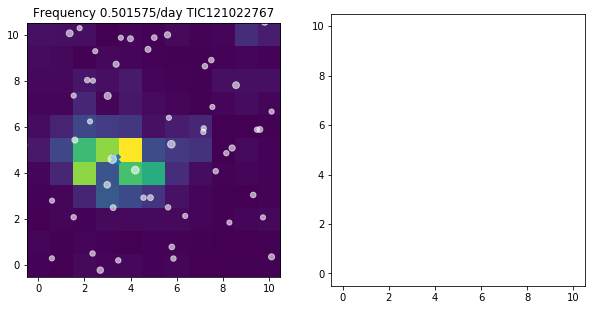

In [99]:

#frequencyheatmapclassk = pmp1.to_frequencymap(frequency_list=[kfreq[1]])
frequencyheatmapclasst = pmp2.to_frequencymap(frequency_list=[tfreq[2]])
g= pmp2.gaiadata
x= g['x']
y= g['y']
size= g['size']

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(frequencyheatmapclasst.heat_stamp,origin=0)
ax[0].set_title('Frequency {0:f}/day TIC{1:d}'.format(tfreq[2],tpf2.targetid))
#ax[1].imshow(frequencyheatmapclassk.heat_stamp,origin=0)
#ax[1].set_title('Frequency {0:f}/day TIC{1:d}'.format(kfreq[1],tpf1.targetid))
#plot the centroid
frequencyheatmapclasst.centroid()
#frequencyheatmapclassk.centroid()

frequencyheatmapclasst.closest_star()
#frequencyheatmapclassk.closest_star()



ax[0].scatter(frequencyheatmapclasst.x,frequencyheatmapclasst.y,marker='X',s=100)
ax[0].scatter(x,y,s=size*5,c='white',alpha=.6)

#ax[1].scatter(frequencyheatmapclassk.x,frequencyheatmapclassk.y,marker='X',s=100)
#ax[1].scatter(x,y,s=size*5,c='white',alpha=.6)
ax[0].set_xlim(-.5,10.5)
ax[0].set_ylim(-.5,10.5)
ax[1].set_xlim(-.5,10.5)
ax[1].set_ylim(-.5,10.5);
frequencyheatmapclasst.closeststar

C:\Users\higgi\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


{'ra': array([286.88995691]),
 'dec': array([37.74435911]),
 'source': array(['2099129703593375232'], dtype=object),
 'x': array([-5.59157423]),
 'y': array([-0.80279968]),
 'size': array([11.30602588])}

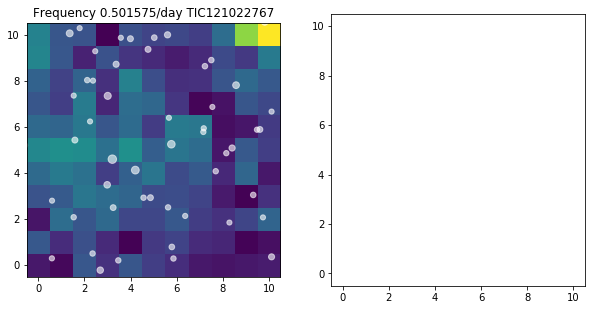

In [112]:

#frequencyheatmapclassk = pmp1.to_frequencymap(frequency_list=[kfreq[1]])
frequencyheatmapclasst = pmp2.to_frequencymap(frequency_list=[tfreq[2]])
g= pmp2.gaiadata
x= g['x']
y= g['y']
size= g['size']

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(frequencyheatmapclasst.heat_stamp,origin=0)
ax[0].set_title('Frequency {0:f}/day TIC{1:d}'.format(tfreq[2],tpf2.targetid))
#ax[1].imshow(frequencyheatmapclassk.heat_stamp,origin=0)
#ax[1].set_title('Frequency {0:f}/day TIC{1:d}'.format(kfreq[1],tpf1.targetid))
#plot the centroid
frequencyheatmapclasst.centroid()
#frequencyheatmapclassk.centroid()

frequencyheatmapclasst.closest_star()
#frequencyheatmapclassk.closest_star()



ax[0].scatter(frequencyheatmapclasst.x,frequencyheatmapclasst.y,marker='X',s=100)
ax[0].scatter(x,y,s=size*5,c='white',alpha=.6)

#ax[1].scatter(frequencyheatmapclassk.x,frequencyheatmapclassk.y,marker='X',s=100)
#ax[1].scatter(x,y,s=size*5,c='white',alpha=.6)
ax[0].set_xlim(-.5,10.5)
ax[0].set_ylim(-.5,10.5)
ax[1].set_xlim(-.5,10.5)
ax[1].set_ylim(-.5,10.5);
frequencyheatmapclasst.closeststar

In [122]:
tpf2.interact()

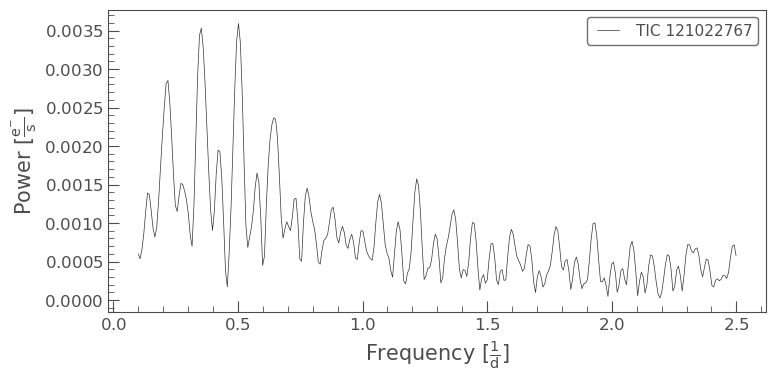

In [113]:
pmp2.periodogram[4][5].plot()

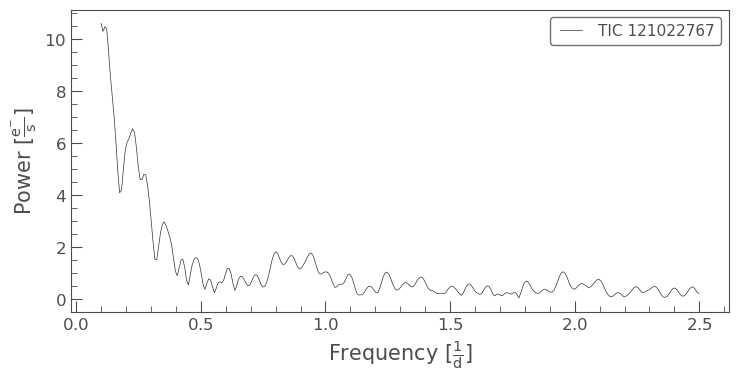

In [108]:
pmp2.periodogram[6][5].plot()

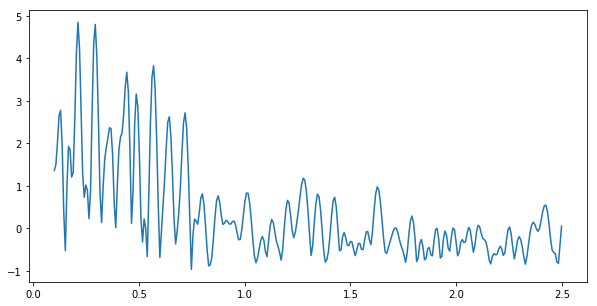

In [119]:
p = pmp2.periodogram[6][5].power/np.nanmedian(pmp2.periodogram[6][5].power)
plt.figure(figsize=(10,5))
plt.plot(pmp2.periodogram[6][5].frequency,p-1)

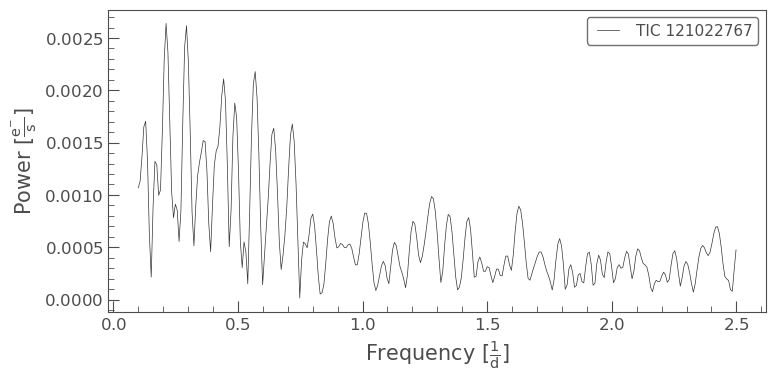

In [120]:
pmp2.periodogram[6][5].plot()